# NBA Covariates
Notebook contains code to extract demographic, performance, team, and city-based features. Used by the notebook `nba-sentiment.ipynb` for regression.

In [13]:
import pandas as pd
import numpy as np
%matplotlib inline

## Load player demographic and performance data
### Demographics
#### Ethnicity and height/weight.
It was difficult to find a list of NBA player ethnicities, so I just googled the few hundred players. I downloaded height and weight information from `basketball-reference.com`.

-I also have data from 2013 onwards; need to update it with race info

In [2]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_players2013.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

Fix heights

In [3]:
demo_df['Ht'] = demo_df['Ht'].str.split('-')
height_dict = {'Jun':72, 'Jul':84, 'May':60}
height_dict.update({str(x):x for x in range(13)})
height_dict.update({'00':0})
demo_df['Ht'] = demo_df['Ht'].apply(lambda row: height_dict[row[0]]*12 + height_dict[row[1]])

#### Player performance
Performance data as also downloaded from `basketball-reference.com`.

In [4]:
'''performance2018_df = spd.get_year_performance_nba(2018).assign(season = lambda row: row['year'] -1)
performance2017_df = spd.get_year_performance_nba(2017).assign(season = lambda row: row['year'] -1)
performance2016_df = spd.get_year_performance_nba(2016).assign(season = lambda row: row['year'] -1)
performance2015_df = spd.get_year_performance_nba(2015).assign(season = lambda row: row['year'] -1)
performance_df = pd.concat([performance2015_df, performance2016_df, performance2017_df, performance2018_df])'''

"performance2018_df = spd.get_year_performance_nba(2018).assign(season = lambda row: row['year'] -1)\nperformance2017_df = spd.get_year_performance_nba(2017).assign(season = lambda row: row['year'] -1)\nperformance2016_df = spd.get_year_performance_nba(2016).assign(season = lambda row: row['year'] -1)\nperformance2015_df = spd.get_year_performance_nba(2015).assign(season = lambda row: row['year'] -1)\nperformance_df = pd.concat([performance2015_df, performance2016_df, performance2017_df, performance2018_df])"

In [5]:
#performance_df.to_csv('d:/data/sentiment_sports/covariates/nba_stats_2015-2018.tsv', sep='\t', index = False)
performance_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_stats_2015-2018.tsv', sep='\t')
performance_df = performance_df.rename(columns = {'TOV%':'TOVP'})

#### Team info
I downloaded team performance data from `basketball-reference.com` as well.

In [6]:
#year=2015
#team2015_df = pd.concat(pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}.html')[:2]).assign(year = year)
# then hand edit the 3-letter team names
team_df = pd.concat([pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2016.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2017.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2018.tsv', sep='\t')])

#### Salary

In [7]:
def get_nba_salary_year(season):
    return (pd.read_html(f'https://hoopshype.com/salaries/players/{season}-{season+1}/')[0]
              .rename(columns = {str(season) + '/' +  str(season+1)[2:]: 'salary'})
              .assign(season = season))
salary_df = pd.concat([get_nba_salary_year(season) for season in range(2010, 2019)])[['Player', 'salary', 'season']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


In [8]:
salary_df['Player'] = salary_df['Player'].str.lower()
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
salary_df['salary'] = salary_df['salary'].str[1:].apply(locale.atoi)

In [11]:
salary_df['standard_salary'] = np.power(salary_df['salary'], 1/4)

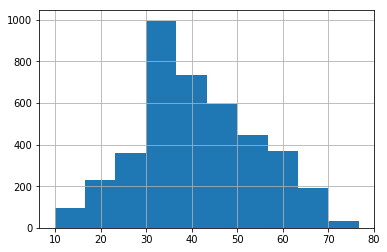

In [14]:
np.power(salary_df['salary'], 1/4).hist();

#### City demographics
When thinking about race, we considered whether the demographics of the city influence player popularity. I downloaded census and polling data for NFL cities.

In [15]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

In [16]:
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

### Combine info
After getting all of the data for various covariates, I combine them into a single dataframe that has performance, demographics, and city information.

In [17]:
covariates_df = (demo_df.merge(performance_df, on = 'Player')
                      .merge(team_df, on=['Tm', 'year'])
                      .merge(city_df, on='Tm')
                      .merge(vote_df, on='Tm') )
covariates_df['Player'] = covariates_df['Player'].str.replace('.', '')
covariates_df = covariates_df.merge(salary_df, on=['Player', 'season'], how='left')
covariates_df['experience'] = covariates_df['year'] - covariates_df['From']
covariates_df.head(2)

,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,...,year,season,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,alex abrines,W,2017,2018,G-F,78,190,"August 1, 1993",NaN,1,...,2017,2016,47,1337075,74.1,10.2,0.1051,5994764.0,49.481519,0
1,steven adams,W,2014,2018,C,84,255,"July 20, 1993",University of Pittsburgh,3,...,2017,2016,47,1337075,74.1,10.2,0.1051,3140517.0,42.096917,3


In [18]:
covariates_df.to_csv('d:/data/sentiment_sports/covariates/nba_player_covariates.tsv', sep='\t', index = False)